# Preface
To enable collaboration, a singularity and venv environment is provided. The idea is that anyone comeing to this project can re-run and edit it. 

Ideally, all relevant data will be stored in an internal database, or, alternatively, in a file location than anyone in the organisation can access. 

On licensing: I'm aware that in a commercial setting licenses do matter. However, in this taks I've excluded that research. 


# Environment Setup
To enable reproducible and collaborative research a common environment is essential. The environment for this project consists of a singularity container in conjunction with a R-renv and python-venv environment. 

Create the following folder structure on your linux system:

```
-demo
    ├── scripts
    ├── envs
    ├── workdir
    └── data
```

The singularity container used in this work is available on dockerhub: [Link](https://hub.docker.com/repository/docker/boeings/r450.python310.ubuntu.22.04)

Navigate to the `envs` directory. 

The commands below contain system specific components which you will have to adapt to your system. 

```{bash}
## Go to envs folder ##
cd envs

## Activate the singularity module ##
ml Singularity/3.6.4

## Pull singularity container from dockerhub
singularity pull docker://boeings/r450.python310.ubuntu.22.04

## Navigating to the workdir ##
cd ../workdir

## Starting the singularity container ##
You need to adjust the file paths for the --bind flag as appropriate on your system.

General syntax:
singularity shell --cleanenv --bind </folder/on/host/system/data>:/data ../envs/r450.python310.ubuntu.22.04_latest.sif

Specific example:
singularity shell --cleanenv --bind /nemo:/nemo,/camp:/camp,/flask:/flask ../envs/r450.python310.ubuntu.22.04_latest.sif

## Or create venv environment in the current folder (change path if you'd like to store the venv environment files elsewhere) ##
This is only required once at the beginning of the project, so will be commented out for now. 
# python3.10 -m venv ../envs/demo_venv_310

## Activate venv environment ##
source ../envs/demo_venv_310/bin/activate

## Save venv.lock documentation file ##
## Save venv package environment     ##
pip freeze > ../envs/venv.lock
## Reload venv environment from venv.lock file ##
pip install -r ../envs/venv.lock

## Start python ##
cd ../workdir
python



# Parameter and Constants

In [1]:
depmap_fn = '../../../../data/depmap/depmap_data_object.pkl'

gtex_fn = '../../../../data/gtex.subset.pkl'

target_gene = "EZH2"

target_complex = ["EZH2" ,"SUZ12", "EED", "RBBP4"]

## Bioplex protein-protein interactions were retrieved from the bioplex website: https://bioplex.hms.harvard.edu/
## This could be done programatically as well. 

target_bioplex_interactors = [
    "EZH2",
    "AEBP2",
    "BTRC",
    "EZH1",
    "EED",
    "EEF1A2",
    "EPOP",
    "FBXW11",
    "HMGB1P1",
    "JARID2",
    "MTF2",
    "PHF1",
    "PHF19",
    "RBBP4",
    "RBBP7",
    "SUZ12",
    "FBXW11",
    "PHF1",
    "SKIDA1"
]


# Data Preparation

## DepMap Data Preparation

In [2]:
###################################################################
## DepMap data preparation                                       ##
## Data preparation chunk. This needs to be run only once.       ##
## Subsequently the data will be loaded in a summary data object ##
###################################################################


import pandas as pd
import numpy as np
import requests
from io import StringIO
import anndata
import mudata
import wrangle_depmap_data

def get_depmap_files(files_url = "https://depmap.org/portal/api/download/files"):
        """Fetch available DepMap files from the portal API"""
        response = requests.get(files_url, timeout=30)
        response.raise_for_status()
        return pd.read_csv(StringIO(response.text))


def load_depmap_file(filename, df_files_filt):
    """Load depmap file, but stop if filename not found."""
    file_sel_df = df_files_filt[df_files_filt['filename'].str.contains(filename)]
    if file_sel_df.empty:
        raise ValueError(f"File matching '{filename}' not found in df_files_filt.")
    file_url = file_sel_df["url"].values[0]
    response = requests.get(file_url, timeout=30)
    response.raise_for_status()
    if filename.endswith('.csv'):
        df_file = pd.read_csv(StringIO(response.text), low_memory=False)
    elif filename.endswith('.txt'):
        df_file = pd.read_csv(StringIO(response.text), sep="\t", low_memory=False)
    else:
        raise ValueError("Unsupported file type")
    return df_file  

## Get recent file list
df_files = get_depmap_files(files_url = "https://depmap.org/portal/api/download/files")

## For duplicated files, keep only the most recent version
# Sort by release_date descending, then drop duplicates keeping the first (latest)
df_files_filt = df_files.sort_values('release_date', ascending=False).drop_duplicates(subset='filename', keep='first')

# tpm OmicsExpressionAllGenesTPMLogp1StrandedProfile.csv
#filename = "OmicsExpressionAllGenesTPMLogp1StrandedProfile.csv"
# filename = "OmicsExpressionTPMLogp1HumanAllGenesStranded.csv"


## Get metadata
# metadata cell lines, screens, genes
filename = "Model.csv"
df_metadata = load_depmap_file(filename = filename, df_files_filt = df_files_filt)
# Set modelID as index in df_metadata for easy alignment
df_metadata = df_metadata.set_index('ModelID')

filename = "OmicsProfiles.csv"
df_profiles = load_depmap_file(filename = filename, df_files_filt = df_files_filt)
df_profiles = df_profiles.set_index('ModelID')

## File selections were made based on paths in https://depmap.org/portal/data_page/?tab=customDownloads

###############################################################################
## Create TPM anndata object                                                 ##
import anndata
import pandas as pd

filename = "OmicsExpressionTPMLogp1HumanProteinCodingGenes.csv"
df_tpm = load_depmap_file(filename = filename, df_files_filt = df_files_filt)
df_tpm = df_tpm[df_tpm["IsDefaultEntryForModel"] == "Yes"]
df_tpm = df_tpm.set_index('ModelID')
cols_to_delete = df_tpm.columns.to_list()[0:5]
cols_to_delete
df_tpm_adata = df_tpm.drop(columns=cols_to_delete)
df_tpm_adata.columns = [col.split(" (")[0] for col in df_tpm_adata.columns]
# Check if columns are unique
df_tpm_adata.columns.is_unique
df_tpm_adata.index.is_unique

# If df_tpm_adata has features as row index and gene names as columns
  # Transpose to have samples/cells as rows and features/genes as columns
adata_tpm = anndata.AnnData(
    X=df_tpm_adata.values,
    obs=pd.DataFrame(index=df_tpm_adata.index),   # samples/cells
    var=pd.DataFrame(index=df_tpm_adata.columns)      # features/genes
)

adata_tpm.obs = adata_tpm.obs.join(df_metadata)


## Done with TPM anndata object                                              ##
###############################################################################

###############################################################################
## Create count data object for differential gene expression                 ##
filename = "OmicsExpressionRawReadCountHumanProteinCodingGenes.csv"
df_counts = load_depmap_file(filename = filename, df_files_filt = df_files_filt)
df_counts = df_counts[df_counts["IsDefaultEntryForModel"] == "Yes"]
df_counts = df_counts.set_index('ModelID')
cols_to_delete = df_counts.columns.to_list()[0:5]
cols_to_delete
df_counts_adata = df_counts.drop(columns=cols_to_delete)
df_counts_adata.columns = [col.split(" (")[0] for col in df_counts_adata.columns]
# Check if rows and columns are unique
df_counts_adata.columns.is_unique
df_counts_adata.index.is_unique

## Done counts                                                               ##
###############################################################################

###############################################################################
## Create CRISPR anndata object                                              ##
import anndata
import pandas as pd

filename = "CRISPRGeneEffect.csv"
df_crispr = load_depmap_file(filename = filename, df_files_filt = df_files_filt)
df_crispr = df_crispr.rename(columns={"Unnamed: 0": "ModelID"})
df_crispr = df_crispr.set_index('ModelID')
df_crispr.columns = [col.split(" (")[0] for col in df_crispr.columns]
# Check if columns are unique
df_crispr.columns.is_unique
df_crispr.index.is_unique


# If df_tpm_adata has features as row index and gene names as columns
  # Transpose to have samples/cells as rows and features/genes as columns
adata_crispr = anndata.AnnData(
    X=df_crispr.values,
    obs=pd.DataFrame(index=df_crispr.index),   # samples/cells
    var=pd.DataFrame(index=df_crispr.columns)      # features/genes
)

adata_crispr.obs = adata_crispr.obs.join(df_metadata)


## Done with TPM anndata object                                              ##
###############################################################################



###############################################################################
## drug response                                                             ##

# drug response metadata
# Create a lookup table between sampleIDs and compound names
filename = "PortalCompounds.csv"
df_compounds = load_depmap_file(filename = filename, df_files_filt = df_files_filt)
df_rename = df_compounds[['CompoundName', 'SampleIDs']]
df_compounds = df_compounds.set_index('SampleIDs')


filename = "../../../../data/depmap/Repurposing_Public_24Q2_Extended_Primary_Data_Matrix.csv"
df_drugs = pd.read_csv(filename )
df_drugs = df_drugs.rename(columns={"Unnamed: 0": "SampleIDs"})
df_drugs = df_drugs.set_index('SampleIDs')

df_drugs = df_drugs.T

df_drugs.columns.is_unique
df_drugs.index.is_unique



adata_drugs = anndata.AnnData(
    X=df_drugs.values,
    obs=pd.DataFrame(index=df_drugs.index),   # samples/cells
    var=pd.DataFrame(index=df_drugs.columns)      # features/genes/drugs
)

## cell line level metadata
adata_drugs.obs = adata_drugs.obs.join(df_metadata)

## Add drug metadata (added to columns)
adata_drugs.var = adata_drugs.var.join(df_compounds, how='left')



## Done                                                                      ##
###############################################################################

###############################################################################
## Copy number variation (CNV)                                               ##

#CN
#filename="OmicsCNGene.csv"
filename="PortalOmicsCNGeneLog2.csv"
df_cn = load_depmap_file(filename = filename, df_files_filt = df_files_filt)
df_cn = df_cn.rename(columns={"Unnamed: 0": "ModelID"})
df_cn = df_cn.set_index('ModelID')
df_cn.columns = [col.split(" (")[0] for col in df_cn.columns]

## keep only column present in df_tpm_adata
df_cn = df_cn[df_cn.columns.intersection(df_tpm_adata.columns)]
df_cn.columns.is_unique
df_cn.index.is_unique

adata_cn = anndata.AnnData(
    X=df_cn.values,
    obs=pd.DataFrame(index=df_cn.index),   # samples/cells
    var=pd.DataFrame(index=df_cn.columns)      # features/genes
)

adata_cn.obs = adata_cn.obs.join(df_metadata)

## Done                                                                      ##
###############################################################################

###############################################################################
## Get common essential genes                                                ##
filename = "../../../../data/AchillesCommonEssentialControls.csv"
df_AchillesCommonEssentialControls = pd.read_csv(filename)

###############################################################################
## protein                                                                   ##
## to be added later - required Uniprot > gene name conversion
filename = "harmonized_RPPA_CCLE.csv"
df_protein = load_depmap_file(filename = filename, df_files_filt = df_files_filt)

## Done                                                                      ##
###############################################################################

###############################################################################
## Other data modalities could be added as needed                            ##

# rnai - can be added later. 
filename = "D2_combined_gene_dep_scores.csv"
df_rnai = load_depmap_file(filename = filename, df_files_filt = df_files_filt)

# filename = "Repurposing_Public_24Q2_Extended_Primary_Data_Matrix.csv"
# df_drugs = load_depmap_file(filename = filename, df_files_filt = df_files_filt)

# methylation
filename = "CCLE_RRBS_TSS_1kb_20180614.txt"
df_methylation = load_depmap_file(filename = filename, df_files_filt = df_files_filt)

## Done optional additions                                                   ##
###############################################################################

##################################################################################
## Initialize depmap data object with loaded datasets                           ##


from wrangle_depmap_data import depmapData

depmap_data = depmapData(
    df_tpm=df_tpm_adata,
    df_counts=df_counts_adata,
    df_cn=df_cn,
    df_drugs=df_drugs,
    df_crispr=df_crispr,
    df_metadata=df_metadata,
    df_profiles=df_profiles
)

## Inspect
depmap_data.data_shapes()

## Subset to cell lines present in all data modalities ##
common_samples = depmap_data.list_common_cell_lines()
common_features = depmap_data.list_common_features()

## Optional: Subset to common cell lines ##
# depmap_data_common = depmap_data.subset_to_common_cell_lines()
# depmap_data_common.data_shapes()

## Optional: Select features of interest ##
#depmap_data_consensus = depmap_data_common.subset_to_common_features()
#depmap_data_consensus.data_shapes()

## Optional: Further subset cells ##
# depmap_data_min = depmap_data_consensus.subset_to_random_cells(n_cells = 100)
#depmap_data_min.data_shapes()

## Check if features of interest are present in all or some modalities
# feature_check = depmap_data_consensus.feature_presence(['EZH1', 'EZH2', 'STK19', 'C7orf26'])


## Check if features of interest are present in the various data modalities
#for key, value in feature_check.items():
#    print(f"Feature: {key}, Present in: {value}")


## save to file ##
outputfile = depmap_fn
depmap_data.save_data(filepath=outputfile)
print(f"Depmap data object saved at {outputfile}")

###################################
## Loading depmap dataset object ##
###################################

import os

if os.path.exists(outputfile):
    print(f"Loading existing depmap_data from {outputfile}")
    depmap_data = depmapData.load_data(outputfile)
else:
    print(f"File {outputfile} not found, using newly created depmap_data object")
    # depmap_data already exists from the creation code above

#####################################
## Done loading depmap data object ##
#####################################


df_metadata: (2132, 48)
df_profiles: (4775, 17)
df_tpm: (1699, 19215)
df_counts: (1699, 19215)
df_cn: (1095, 18399)
df_drugs: (919, 6790)
df_crispr: (1186, 18435)
Number of common cell lines: 544
Number of common features: 18118
Depmap data object saved at ../../../../data/depmap/depmap_data_object.pkl
Loading existing depmap_data from ../../../../data/depmap/depmap_data_object.pkl


## GTEx data preparation

In [3]:
###################################################################
## GTEx data preparation                                         ##
## Data preparation chunk. This needs to be run only once.       ##
## Subsequently the data will be loaded in a summary data object ##
###################################################################

import pandas as pd
import numpy as np

## Step 1: Load metadata
## Setep 2: Subset metadata 
## step 3 : preare count data
## step 4: prepare tpm data

FNmeta = "/nemo/stp/babs/working/boeings/Projects/boeings/stefan.boeing/620_demo_GTEx/data/GTEx_Analysis_v10_Annotations_SampleAttributesDS.txt"

df_meta = pd.read_csv(
    FNmeta,
    sep="\t"
)
df_meta_sel = df_meta[['SAMPID', 'SMTS', 'SMAFRZE']].copy()

## Add Subjid
df_meta_sel['SUBJID'] = df_meta_sel['SAMPID'].str.split('-').str[:2].str.join('-')


## Load phenotype data
FNmeta = "/nemo/stp/babs/working/boeings/Projects/boeings/stefan.boeing/620_demo_GTEx/data/GTEx_Analysis_v10_Annotations_SubjectPhenotypesDS.txt"
df_pheno = pd.read_csv(
    FNmeta,
    sep="\t"
)

df_joined = pd.merge(df_pheno, df_meta_sel, on="SUBJID", how="inner")
df_joined['SEX'] = df_joined['SEX'].replace({1: 'M', 2: 'F'})
df_joined['SMTS'] = df_joined['SMTS'].str.replace(' ', '')

## Filter for specific tissue or subset ##
## Filter on Method
## List all methods
available_methods = sorted(df_joined['SMAFRZE'].dropna().unique().tolist())
print(f"Available methods: {available_methods}")

## Filter on RNASeq
df_gtex_meta = df_joined[df_joined['SMAFRZE'] == 'RNASEQ']

df_gtex_meta.set_index('SAMPID', inplace=True)

## List available tissue
available_tissues = sorted(df_gtex_meta['SMTS'].dropna().unique())
print(f"Available tissues: {available_tissues}")

## Optional filtering on tissue ##

## Optional filtering on age range ##



## Optional: plot gender/age/organ distribution ##

######################################
## Load gtex  count data and subset ##
######################################

## Load count data
##    Selections: column names / cell ids
##    Min-count per row filtering (default row mean >= 1)

FNgtex = "/nemo/stp/babs/working/boeings/Projects/boeings/stefan.boeing/620_demo_GTEx/data/GTEx_Analysis_v10_RNASeQCv2.4.2_gene_reads.gct.gz"
df_count_gtex = pd.read_csv(
    FNgtex,
    sep="\t",
    skiprows=2, 
    low_memory=False
)
df_count_gtex.shape
## To speed up DGE comparisons, filter for lowly expressed genes. 
## Here we will require at least one count per sample on average
df_count_gtex.rename(columns={'Description': 'gene_id'}, inplace=True)
df_count_gtex.set_index('gene_id', inplace=True)

numeric_cols = df_count_gtex.select_dtypes(include='number').columns

df_count_gtex = df_count_gtex[numeric_cols]

## Check df_count_gtext
# Get all sample IDs present in the metadata
sampid_set = set(df_gtex_meta.index)
# Get the intersection of sample IDs present in both metadata and count data
sample_ids = [col for col in df_count_gtex.columns if col in sampid_set]
df_count_gtex = df_count_gtex[sample_ids]



## Select random sample ids ##
# Randomly select n_samples rows from the dataframe
# n_samples = 100
# n_to_select = min(n_samples, len(sampid_set))
# subset_sample_ids = np.random.choice(sampid_set, size=n_to_select, replace=False).tolist()

# df_count_gtex_subset = df_count_gtex[subset_sample_ids]
# df_count_gtex = df_count_gtex_subset.copy()

## Filter features based on row averages ##

# Filter rows with no or minimal expression #
# min_rowcount = 1 * len(df_count_gtex.columns)
min_rowcount = 1

df_count_gtex = df_count_gtex[df_count_gtex.mean(axis=1) >= min_rowcount]
df_count_gtex.shape

#############################################
## Load tpm data based on count selections ##
#############################################

samples = df_count_gtex.columns.tolist()
features = df_count_gtex.index.tolist()

## Load tpm data ##
FNgtex_tpm = "/nemo/stp/babs/working/boeings/Projects/boeings/stefan.boeing/620_demo_GTEx/data/GTEx_Analysis_v10_RNASeQCv2.4.2_gene_tpm.gct.gz"
df_tpm_gtex = pd.read_csv(
    FNgtex_tpm,
    sep="\t",
    skiprows=2, 
    low_memory=False
)
df_tpm_gtex.shape

df_tpm_gtex.rename(columns={'Description': 'gene_id'}, inplace=True)
df_tpm_gtex.set_index('gene_id', inplace=True)

numeric_cols = df_tpm_gtex.select_dtypes(include='number').columns

df_tpm_gtex = df_tpm_gtex[numeric_cols]

# Get intersection of available features and samples
available_features = [f for f in features if f in df_tpm_gtex.index]
available_samples = [s for s in samples if s in df_tpm_gtex.columns]

# Subset the DataFrame
existing_features = [f for f in available_features if f in df_tpm_gtex.index]
existing_samples = [f for f in available_samples if f in df_tpm_gtex.columns]

## df_tpm_gtex contains duplicated rows
duplicates = df_tpm_gtex.index[df_tpm_gtex.index.duplicated()]
print(f"Number of duplicated gene_ids: {len(duplicates)}")

## Remove duplicates (keep the row with the highest row sum)
# Calculate row sums
row_sums = df_tpm_gtex.sum(axis=1)

# Create a DataFrame with row sums
df_with_sum = df_tpm_gtex.copy()
df_with_sum['row_sum'] = row_sums

# Sort by row_sum descending, so the highest is first for each gene
df_with_sum = df_with_sum.sort_values('row_sum', ascending=False)

# Drop duplicates, keeping the first (which has the highest sum)
df_tpm_gtex_nodup = df_with_sum[~df_with_sum.index.duplicated(keep='first')]

# Remove the row_sum column
df_tpm_gtex_nodup = df_tpm_gtex_nodup.drop(columns=['row_sum'])

unique_list = list(dict.fromkeys(available_samples))

df_tpm_gtex = df_tpm_gtex_nodup.loc[available_features, available_samples].copy()

## Get df_tpm_ features that

## Subsetting df_count_gtex amd df_meta_gtex again
df_count_gtex_unique = df_count_gtex[~df_count_gtex.index.duplicated(keep='first')]
df_count_gtex = df_count_gtex_unique.loc[df_tpm_gtex.index, df_tpm_gtex.columns].copy()


##########################
## Obtaining GTEx Data  ##
##########################



from wrangle_gtex_data import gtexData

gtex_data = gtexData(
    df_metadata=df_gtex_meta,
    df_tpm=df_tpm_gtex,
    df_counts=df_count_gtex,
)

gtex_data.data_shapes()

gtex_data.save_data(gtex_fn)

/tmp/ipykernel_115932/4024782846.py:17: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  df_meta = pd.read_csv(


Available methods: ['DEEPWGS', 'EXCLUDE', 'OMNI', 'RNASEQ', 'SMLRNA', 'WES', 'WGS']
Available tissues: ['AdiposeTissue', 'AdrenalGland', 'Bladder', 'Blood', 'BloodVessel', 'Brain', 'Breast', 'CervixUteri', 'Colon', 'Esophagus', 'FallopianTube', 'Heart', 'Kidney', 'Liver', 'Lung', 'Muscle', 'Nerve', 'Ovary', 'Pancreas', 'Pituitary', 'Prostate', 'SalivaryGland', 'Skin', 'SmallIntestine', 'Spleen', 'Stomach', 'Testis', 'Thyroid', 'Uterus', 'Vagina']
df_metadata: (19788, 6)
df_tpm: (19616, 37756)
df_counts: (19616, 37756)


# Part A - characterization of a target gene and identification of appropriate cell lines
## Complex Membership

In [23]:
import warnings
warnings.filterwarnings('ignore')

## Loading of all relevant data ##
depmap_data.target_gene = target_gene
depmap_data.target_complex = target_complex

## EZH2 interactors based on the bioplex resource ##
depmap_data.target_bioplex_interactors = target_bioplex_interactors

## We start by checking if our gene of interest is in the common essential genes, in which case the DepMap data is not very informative
filename = "../../../../data/AchillesCommonEssentialControls.csv"
df_essential = pd.read_csv(filename)
depmap_data.AchillesCommonEssentialControls = df_essential

depmap_data.save_data(depmap_fn)

if (target_gene in df_essential['gene_id'].values):
    print(f"Warning: {target_gene} is classified as common essential gene in DepMap functional genomic screens.")
else:
    print(f"Good news: {target_gene} is not classified as common essential gene in DepMap functional genomic screens.")


Good news: EZH2 is not classified as common essential gene in DepMap functional genomic screens.


df_metadata: (19788, 6)
df_tpm: (19616, 37756)
df_counts: (19616, 37756)
         overall_mean  tau_score  tau_score_F  tau_score_M max_tissue  \
gene_id                                                                 
GAPDHS          10.24        1.0         0.93          1.0     Testis   
ATP4A           26.42        1.0         1.00          1.0    Stomach   
CPB2             1.80        1.0         1.00          1.0      Liver   
PRSS55           0.68        1.0         0.89          1.0     Testis   
PRSS58           0.97        1.0         0.81          1.0     Testis   

        EC_enzymatic_activity  
gene_id                        
GAPDHS               1.2.1.12  
ATP4A                7.2.2.19  
CPB2                3.4.17.20  
PRSS55               3.4.21.-  
PRSS58               3.4.21.4  


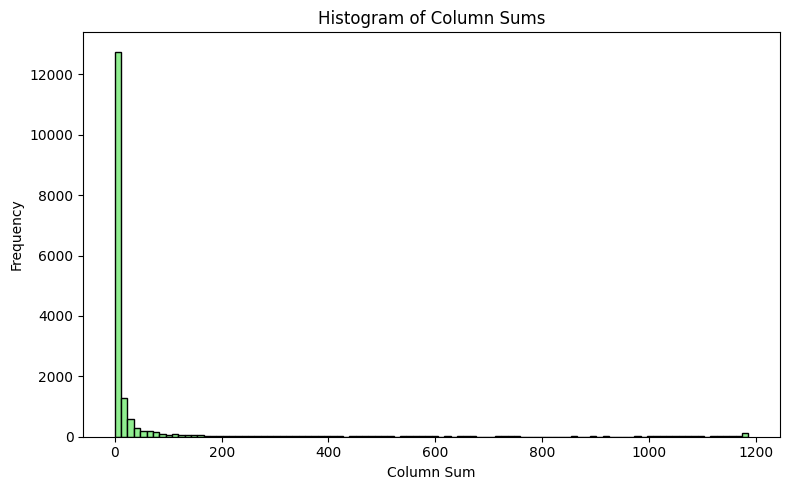

In [9]:
## Load gtex data object ##
from wrangle_gtex_data import gtexData
import pandas as pd
import numpy as np

gtex_data = gtexData.load_data(gtex_fn)
gtex_data.data_shapes()

df_meta = gtex_data.df_metadata

df_tpm = gtex_data.df_tpm

df_tau = df_tpm.T

# Create a mapping dictionary from SAMPID to SMTS
sampid_to_smts = df_meta['SMTS'].to_dict()

## Replace sample ids with class labels
df_tau = df_tau.rename(columns=sampid_to_smts)

# Calculate tissue mean
df_tissue_mean = df_tau.groupby(df_tau.columns, axis=1).mean()
df_overall_mean = df_tau.T.mean()

def calculate_tau(expression_vector):
  """
  Calculate tau score for tissue specificity.
  Tau score ranges from 0 (ubiquitously expressed) to 1 (tissue-specific).
  Formula: τ = (1/(n-1)) × Σ(1 - xi/xmax)
  where xi is expression in tissue i, xmax is maximum expression
  """
  # Normalize by maximum expression
  max_expr = expression_vector.max()
  if max_expr == 0:
      return 0

  normalized = expression_vector / max_expr
  n = len(expression_vector)
  tau = (1 / (n - 1)) * np.sum(1 - normalized)
  return tau

# Calculate tau for each gene across tissues
tau_scores = df_tissue_mean.apply(calculate_tau, axis=1)

# Get the column name with the highest value for each gene
# df_max_tissue = df_tau.idxmax(axis=1).to_frame('max_tissue')


##########################################
## Calculate male and female tau_scores ##
##########################################
 
df_meta['SMTS_SEX'] = df_meta['SMTS'].astype(str) + '_' + df_meta['SEX'].astype(str)
df_meta_F = df_meta[df_meta['SEX'] == "F"]
samples_F = df_meta_F.index
df_tau_F = df_tpm.T
df_tau_F = df_tau_F.loc[:, df_tau_F.columns.intersection(samples_F)].copy()
sampid_to_smts_F = df_meta_F['SMTS_SEX'].to_dict()
df_tau_F_subset = df_tau_F.rename(columns=sampid_to_smts_F)
df_tissue_mean_F = df_tau_F_subset.groupby(df_tau_F_subset.columns, axis=1).mean()
tau_scores_F = df_tissue_mean_F.apply(calculate_tau, axis=1)

df_meta_M = df_meta[df_meta['SEX'] == "M"]
samples_M = df_meta_M.index
df_tau_M = df_tpm.T
df_tau_M = df_tau_M.loc[:, df_tau_M.columns.intersection(samples_M)].copy()
sampid_to_smts_M = df_meta_M['SMTS_SEX'].to_dict()
df_tau_M_subset = df_tau_M.rename(columns=sampid_to_smts_M)
df_tissue_mean_M = df_tau_M_subset.groupby(df_tau_M_subset.columns, axis=1).mean()
tau_scores_M = df_tissue_mean_M.apply(calculate_tau, axis=1)


# Merge df_overall_mean, tau_scores and df_max_tissue by gene_id index
df_merged = pd.DataFrame({
    'overall_mean': df_overall_mean,
    'tau_score': tau_scores,
    'tau_score_F': tau_scores_F,
    'tau_score_M': tau_scores_M,
    'max_tissue': df_tau.idxmax(axis=1)
})

# Round only numeric columns to 2 decimal places
df_merged[df_merged.select_dtypes(include='number').columns] = df_merged.select_dtypes(include='number').round(2)



# Sort by tau_score from lowest to hightest
df_merged = df_merged.sort_values('tau_score', ascending=False)




################################
## Load enzymatic activities  ##
################################

FN = "/nemo/stp/babs/working/boeings/Projects/boeings/stefan.boeing/625_liver_cancer_target_report/data/uniprot.enzymatic.activities.w.gene.ids.txt"

df_enzymes = pd.read_csv(FN, sep="\t")
df_enzymes = df_enzymes[['Gene Names (primary)', 'EC number']].drop_duplicates()
df_enzymes = df_enzymes.groupby('Gene Names (primary)')['EC number'].apply(lambda x: '; '.join(x.dropna().astype(str))).reset_index()

# Or if you want to rename multiple columns at once
df_enzymes = df_enzymes.rename(columns={
    'Gene Names (primary)': 'gene_id',
    'EC number': 'ec_number'  # if you also want to rename this one
})

## Example subsetting all enzymes to kinases ##
# EC class phosphotransferases: 2.7

df_kinases = df_enzymes[
    (df_enzymes['ec_number'].str.startswith('2.7.', na=False)) & 
    (~df_enzymes['ec_number'].str.contains('.2.7.', na=False))
]

## End subset example ##


##################################################################
## Mark all genes that have any enzymatic activity in df_merged ##
##################################################################
# Create a mapping dictionary from df_enzymes
gene_to_ec = df_enzymes.set_index('gene_id')['ec_number'].to_dict()

df_merged['EC_enzymatic_activity'] = df_merged.index.map(gene_to_ec)
df_merged['EC_enzymatic_activity'] = df_merged['EC_enzymatic_activity'].fillna('')

################################################
## Now reduce to genes with enzymatic activty ##
################################################

df_merged_with_activity = df_merged[df_merged['EC_enzymatic_activity'] != "" ]
print(df_merged_with_activity.head(5))


######################################
## Add common essential information ##
######################################
filename = "../../../../data/AchillesCommonEssentialControls.csv"
df_add = pd.read_csv(filename)
df_add['crisprCommonEssential'] = "+"
df_add = df_add.set_index('gene_id')
df_add = df_add.drop('N', axis=1)

df_merged = df_merged.join(df_add, how='outer')

# Replace NaN in crisprCommonEssential with empty string
df_merged = df_merged.fillna("")


## Let's start by removing common essential genes from consideration
filename = "../../../../data/AchillesCommonEssentialControls.csv"
df_essential = pd.read_csv(filename)
essential_genes = df_essential['gene_id']


depmap_data = depmapData.load_data(depmap_fn)
df_binary = depmap_data.df_crispr
## Remove essential genes ##
df_binary =df_binary.drop(columns=[col for col in essential_genes if col in df_binary.columns]).copy()


df_binary = (df_binary < depmap_data.cut_off).astype(int).copy()
df_column_sums = df_binary.sum(axis=0)
df_column_sums = df_column_sums.sort_values(ascending=False).copy()

#import matplotlib.pyplot as plt
# plt.figure(figsize=(8, 5))
# plt.hist(df_column_sums.values, bins=100, color='lightgreen', edgecolor='black')
# plt.xlabel('Column Sum')
# plt.ylabel('Frequency')
# plt.title('Histogram of Column Sums')
# plt.tight_layout()
# plt.show()


## add to df_merged with activity
df_column_sums = df_column_sums.to_frame(name='N_lines_dependent')
df_merged = df_merged.join(df_column_sums, how='outer')
df_merged = df_merged.fillna(0)
df_merged['N_lines_dependent'] = df_merged['N_lines_dependent'].round().astype('Int64')


## Save ##
df_merged.to_csv("../../../../data/gtex.gene.level.metadata.csv")

## Add to gtex data object
gtex_data.gene_metadata = df_merged

gtex_data.save_data(gtex_fn)

## Show GTEx expression pattern for target gene

In [10]:
## Load gtex data object ##
from wrangle_gtex_data import gtexData
import pandas as pd
import numpy as np

gtex_data = gtexData.load_data(gtex_fn)
gtex_data.data_shapes()

df_tpm = gtex_data.df_tpm

df_meta = gtex_data.df_metadata
df_meta['SMTS_SEX'] = df_meta['SMTS'] + '_' + df_meta['SEX']

gene_sel = df_tpm[[target_gene]].copy()

print(df_merged.loc[target_gene])

df_metadata: (19788, 7)
df_tpm: (19616, 37756)
df_counts: (19616, 37756)
overall_mean                  5.84
tau_score                     0.86
tau_score_F                   0.73
tau_score_M                   0.87
max_tissue                   Blood
EC_enzymatic_activity    2.1.1.356
crisprCommonEssential             
N_lines_dependent               69
Name: EZH2, dtype: object


In [11]:
gene_sel = df_tpm[[target_gene]].copy()
gene_sel['sample_id'] = gene_sel.index
df_plot = gene_sel.merge(df_meta[['SMTS_SEX']], left_on='sample_id', right_index=True)
df_plot = df_plot.rename(columns={target_gene: 'expression', 'SMTS_SEX': 'tissue_gender'})

## Create color platette ##
import seaborn as sns
import matplotlib.pyplot as plt

# Get unique tissue_gender values
tissue_genders = df_plot['tissue_gender'].unique()

# Extract base tissues
base_tissues = sorted(set([tg.split('_')[0] for tg in tissue_genders]))

# Assign a base color to each tissue
base_palette = sns.color_palette('tab20', n_colors=len(base_tissues))
base_color_map = dict(zip(base_tissues, base_palette))

# Build the palette dictionary
palette = {}
for tg in tissue_genders:
    tissue, gender = tg.split('_')
    base_color = base_color_map[tissue]
    # Use a lighter shade for F, darker for M
    if gender == 'F':
        shade = sns.light_palette(base_color, n_colors=3)[1]
    else:
        shade = sns.dark_palette(base_color, n_colors=3)[1]
    palette[tg] = shade


# Get unique tissue_genders and base tissues
tissue_genders = df_plot['tissue_gender'].unique()
base_tissues = sorted(set([tg.split('_')[0] for tg in tissue_genders]))

# Build the order: for each tissue, _F then _M if present
order = []
for tissue in base_tissues:
    for gender in ['F', 'M']:
        tg = f"{tissue}_{gender}"
        if tg in tissue_genders:
            order.append(tg)

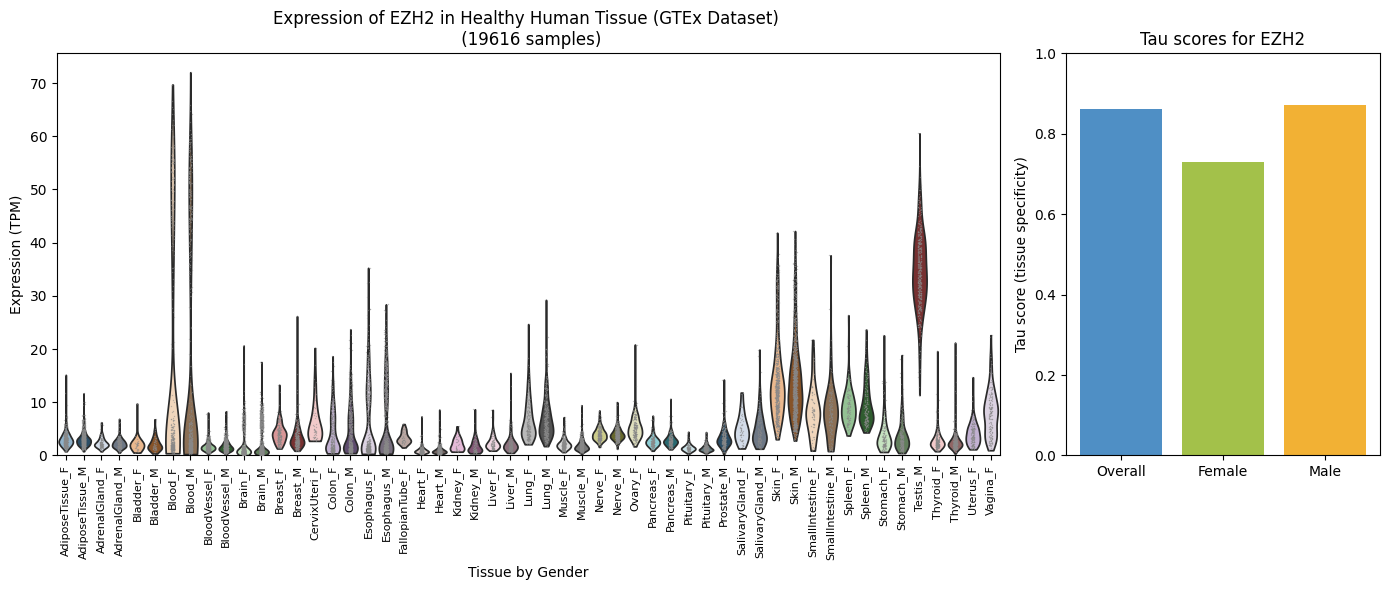

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

# Get tau score for the target gene
tau_value = df_merged.loc[target_gene, 'tau_score']
tau_value_F = df_merged.loc[target_gene, 'tau_score_F']
tau_value_M = df_merged.loc[target_gene, 'tau_score_M']

bar_labels = ['Overall', 'Female', 'Male']
bar_values = [tau_value, tau_value_F, tau_value_M]

fig, axes = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [3, 1]})

axes[1].bar(bar_labels, bar_values, color=['#4F8FC5', '#A3C14A', '#F2B134'])
axes[1].set_ylabel('Tau Score')
#axes[1].set_title(f'Tau Scores for {target_gene}')


# Left: Violin + dots
sns.violinplot(
    data=df_plot,
    x='tissue_gender',  # or 'Tissue', match your column name
    y='expression',
    palette=palette,
    order=order,
    cut=0,
    inner=None,
    ax=axes[0]
)
sns.stripplot(
    data=df_plot,
    x='tissue_gender',
    y='expression',
    color='#888888',
    size=1,
    jitter=True,
    alpha=0.5,
    ax=axes[0]
)

num_rows = df_plot.shape[0]
axes[0].set_title(f"Expression of {target_gene} in Healthy Human Tissue (GTEx Dataset) \n ({num_rows} samples)")
axes[0].set_xlabel("Tissue by Gender")
axes[0].set_ylabel("Expression (TPM)")
axes[0].tick_params(axis='x', rotation=90)
axes[0].set_ylim(bottom=0)
axes[0].set_xticklabels(axes[0].get_xticklabels(), fontsize=8)

# Right: Tau bar
axes[1].bar(bar_labels, bar_values, color=['#4F8FC5', '#A3C14A', '#F2B134'])
axes[1].set_ylim(0, 1)
axes[1].set_ylabel("Tau score (tissue specificity)")
axes[1].set_title(f"Tau scores for {target_gene}")
axes[1].set_xticks(range(len(bar_labels)))
axes[1].set_xticklabels(bar_labels)

plt.tight_layout()
plt.savefig("../../../../input_figures/gtex.png")

plt.show()


With the Kendall tau-metric we can get an idea how tissue specific the expression of a given gene is. In addition, we also get an idea if the expression pattern in healthy tissue is similar in male and female patients. For the cell line selection in our example case we also get an idea what tissue might be good to focus on as cell line source. 

    - [ ] Gender imbalance at the expression level > Gender-specific model systems
    - [ ] Overview of tissue specificity of the expression of the target gene > Ideal narrow expression, fewer chances of side effects
    - [ ] Overall expression levels of the target gene in various tissues

In [13]:
## DepMap Characterization

## Load deepmap data ##
#from wrangle_depmap_data import depmapData
import wrangle_depmap_data
import os

###################################
## Loading depmap dataset object ##
###################################


outputfile = depmap_fn
if os.path.exists(outputfile):
    print(f"Loading existing depmap_data from {outputfile}")
    depmap_data = depmapData.load_data(outputfile)
else:
    print(f"File {outputfile} not found, using newly created depmap_data object")
    # depmap_data already exists from the creation code above

depmap_data.data_shapes()



df_cn = depmap_data.df_cn

#############################################
## Create score matrix for the target gene ##
#############################################
df_meta_dep = depmap_data.df_metadata
df_target_score = df_meta_dep
df_target_score.to_csv("../../../../data/temp5.csv")

## Get dependency score
df_crispr_dep = depmap_data.df_crispr
df_temp_c = df_crispr_dep[target_gene]
df_temp_c = df_temp_c.to_frame(name=f"crispr_dep_score_{target_gene}")

##  Get expression
df_tpm_dep = depmap_data.df_tpm
df_temp_t = df_tpm_dep[target_gene]
df_temp_t = df_temp_t.to_frame(name=f"expr_tpm_{target_gene}")

## Get CNV
df_cn_dep = depmap_data.df_cn
df_temp_cn = df_cn_dep[target_gene]
df_temp_cn = df_temp_cn.to_frame(name=f"cn_{target_gene}")

## drugs later
df_drugs_dep = depmap_data.df_drugs


from functools import reduce

dfs = [df_target_score, df_temp_c, df_temp_t, df_temp_cn]
df_target_score = reduce(lambda left, right: left.join(right, how='outer'), dfs)

## Store in depmap data object
depmap_data.df_target_score = df_target_score

## guidance: determine what two standard deviations are
std_dev = df_crispr_dep[target_gene].std()
two_std = 2 * std_dev
two_std = two_std.round(2)
print(f"Two standard deviations down equals: {-1 * two_std}")

## Set Cut of for model selection
if (-1* two_std < -0.5):
    cut_off = -1 * two_std
    depmap_data.cut_off = cut_off
else:
    cut_off = -0.5
    depmap_data.cut_off = cut_off

## Select Models below cut-off
dfSel = df_crispr_dep[target_gene].to_frame(name=target_gene)
dfSel = dfSel[dfSel[target_gene] <= cut_off]
selected_modelIDs = dfSel.index
depmap_data.selected_modelIDs = selected_modelIDs

## Save
# df_target_score.to_csv("../../../../data/temp.target.score.csv")
depmap_data.save_data(filepath=depmap_fn)
print(f"Depmap data object saved at {depmap_fn}")

Loading existing depmap_data from ../../../../data/depmap/depmap_data_object.pkl
df_metadata: (2132, 48)
df_profiles: (4775, 17)
df_tpm: (1699, 19215)
df_counts: (1699, 19215)
df_cn: (1095, 18399)
df_drugs: (919, 6790)
df_crispr: (1186, 18435)
Two standard deviations down equals: -0.51
Depmap data object saved at ../../../../data/depmap/depmap_data_object.pkl


In [14]:
# Make Boxplot for target gene by tissue

In [15]:
## Find all modelIDs below target value
# Select the column for the target gene
gene_values = df_crispr_dep[target_gene]

# Find modelIDs where the value is less than cut_off
selected_modelIDs = gene_values[gene_values < cut_off].index.tolist()

print(len(selected_modelIDs))

## Get metadata for cell lines selected for consideration
df_meta_profiles = depmap_data.df_target_score.loc[selected_modelIDs].drop_duplicates()

unique_models = df_meta_profiles.index
unique_models = unique_models[~unique_models.duplicated(keep=False)]

print(f"{len(unique_models)} unique model systems to consider")

print(df_meta_profiles)


69
69 unique model systems to consider
            PatientID CellLineName StrippedCellLineName DepmapModelType  \
ModelID                                                                   
ACH-000247  PT-JKf5mS       OCUM-1                OCUM1           DSTAD   
ACH-000793  PT-xOmD9v     KATO III              KATOIII           SSRCC   
ACH-000922  PT-0mdkef      RCH-ACV               RCHACV            BALL   
ACH-001544  PT-VFQOly       KYAE-1                KYAE1            ESCA   
ACH-002284  PT-f93T4X          NB6                  NB6             NBL   
...               ...          ...                  ...             ...   
ACH-001197  PT-3YIeN9        SMZ-1                 SMZ1            MTNN   
ACH-001616  PT-oQqqCS     OCI-LY18              OCILY18        DLBCLNOS   
ACH-001685  PT-A1mKo8        U-HO1                 UHO1              HL   
ACH-002202  PT-xnqeDr        TMK-1                 TMK1            STAD   
ACH-002490  PT-0a2F5a    NCI-H1882             NCIH1882      

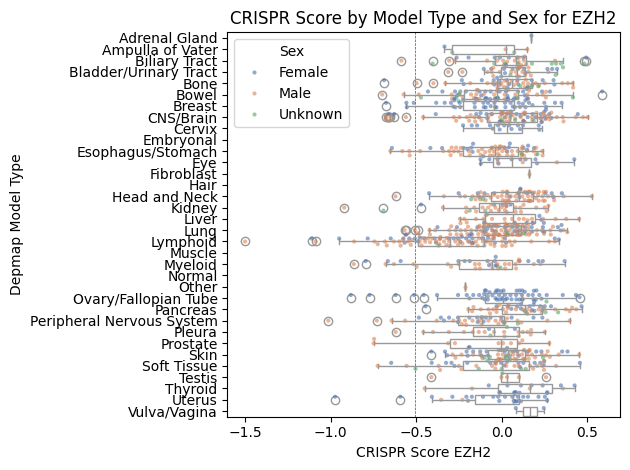

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

df_temp = df_crispr_dep[target_gene]
df_plot = df_meta_dep.join(df_temp, how='outer')
df_plot = df_plot.rename(columns={target_gene: 'crispr_dep_score'})

y_order = sorted(df_plot['OncotreeLineage'].dropna().unique())


sns.boxplot(
    data=df_plot,
    y='OncotreeLineage',
    x='crispr_dep_score',
    orient='h',
    order = y_order,
    color='white',  # Single color for all boxes
    showcaps=True,
    boxprops={'facecolor':'none', "zorder":10},
    whiskerprops={'zorder':10},
    medianprops={'zorder':11}
)

# Add vertical red line (e.g., at x=0)
plt.axvline(x=cut_off, color='red', linestyle='--', linewidth=0.5, zorder=1)

sns.swarmplot(
    data=df_plot,
    y='OncotreeLineage',
    x='crispr_dep_score',
    hue='Sex',
    orient='h',
    dodge=True,
    size=3,
    alpha=0.6,
    palette='deep'
)
plt.xlabel(f'CRISPR Score {target_gene}')
plt.ylabel('Depmap Model Type')
plt.title(f'CRISPR Score by Model Type and Sex for {target_gene}')

# Remove duplicate legend entries
handles, labels = plt.gca().get_legend_handles_labels()
n = len(set(df_plot['Sex']))
plt.legend(handles[:n], labels[:n], title='Sex')

plt.tight_layout()
plt.savefig("../../../../input_figures/scores.per.celltype.png")
plt.show()

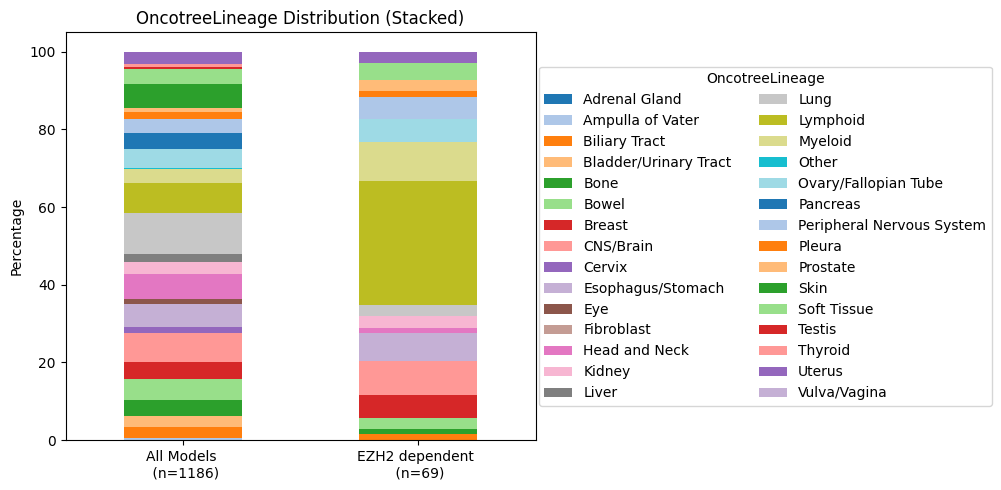

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter df_meta_dep to only modelIDs present in df_crispr_dep
df_ts = depmap_data.df_target_score
df_meta_dep_filtered = df_ts.loc[df_ts.index.intersection(df_crispr_dep.index)]

# Calculate absolute counts for all modelIDs
all_counts = df_meta_dep_filtered['OncotreeLineage'].value_counts()

# Calculate absolute counts for selected_modelIDs
selected = df_meta_dep_filtered.loc[df_meta_dep_filtered.index.intersection(selected_modelIDs)]
sel_counts = selected['OncotreeLineage'].value_counts()

# Combine counts into a DataFrame
df_plot = pd.DataFrame({'All Models': all_counts, f'{target_gene} dependent': sel_counts}).fillna(0)


# Transpose for stacked bar chart (categories as rows)
df_plot = df_plot.T

df_plot = df_plot.div(df_plot.sum(axis=1), axis=0) * 100

# Plot
fig, (ax, ax_legend) = plt.subplots(
    ncols=2,
    figsize=(10, 5),
    gridspec_kw={'width_ratios': [4, 1]},
    constrained_layout=True
)

# Plot on the left axis
df_plot.plot(
    kind='bar',
    stacked=True,
    color=plt.cm.tab20.colors[:len(df_plot.columns)],
    ax=ax,
    legend=False
)
ax.set_ylabel('Percentage')
ax.set_title('OncotreeLineage Distribution (Stacked)')
ax.set_xticks(range(len(df_plot.index)))
custom_labels = [f'All Models \n (n={sum(all_counts)})', f'{target_gene} dependent \n (n={sum(sel_counts)})']
ax.set_xticklabels(custom_labels, rotation=0)
# ax.set_xticklabels(df_plot.index, rotation=0)

# Legend on the right axis, with two columns
handles, labels = ax.get_legend_handles_labels()
ax_legend.axis('off')
ax_legend.legend(
    handles,
    labels,
    title='OncotreeLineage',
    ncol=2,  # Two columns
    loc='center'
)

plt.tight_layout()
plt.savefig("../../../../input_figures/dependency.percentages.png", bbox_inches='tight')
plt.show()

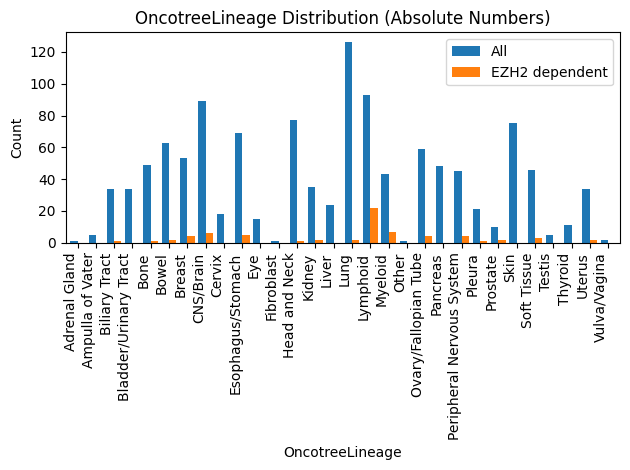

In [18]:


# Combine into a DataFrame for plotting
df_plot = pd.DataFrame({'All': all_counts, f'{target_gene} dependent': sel_counts}).fillna(0)

# Plot
df_plot.plot(kind='bar', width=0.8)
plt.ylabel('Count')
plt.title('OncotreeLineage Distribution (Absolute Numbers)')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

## Find correlated dependencies
Genes that exhibit correlated functional data = correlated dependency scores might be part of the same functional pathway - either within the exact same pathway further up- or downstream or in a paralell, potentially redundant pathway. 

In [19]:
## Before calculating the correlation we're going to remove the common essential genes

df_merged = gtex_data.gene_metadata
# df_merged = pd.read_csv("../../../../data/gtex.gene.level.metadata.csv")


commonEssential = df_merged[df_merged['crisprCommonEssential'] == "+"].index

df_subset = df_crispr_dep.drop(columns=[col for col in commonEssential if col in df_crispr_dep.columns])

## Calculate correlation ##

## This is compute intense, so we are going to do this calculation only if it's not present in our data object
if not hasattr(depmap_data, "crispr_gene_cor_matrix"):
    corr_matrix = df_subset.corr(method='pearson')
    depmap_data.crispr_gene_cor_matrix = corr_matrix
    depmap_data.save_data(depmap_fn)
else:
    corr_matrix = depmap_data.crispr_gene_cor_matrix

df_target_cor = corr_matrix[[target_gene]]

df_target_cor_sorted = df_target_cor.sort_values(by=target_gene, ascending=False)


## Calculate number of other dependencies based on the cut-off below
## Note the score_cut off could also be defined, for example, as below 2 standard deviations of the mean for each gene. For simplicity I'll set it to -0.5 in this example. 
score_cut_off = -0.5
df_corr_score = (df_subset < score_cut_off).astype(int)
col_sums = df_corr_score.sum(axis=0)
df_columns = pd.DataFrame(col_sums, columns=['N_total_dendencies'])
df_columns.index.name = 'gene_id' 

## Calculate the number of commen dependencies with target gene
df_target_dep_subset = df_subset[df_subset[target_gene] < score_cut_off]
df_target_corr_score = (df_target_dep_subset < score_cut_off).astype(int)
target_col_sums = df_target_corr_score.sum(axis=0)
df_target_columns = pd.DataFrame(target_col_sums, columns=[f'N_{target_gene}_dendencies'])
df_target_columns.index.name = 'gene_id' 

## Add enzymatic activites
df_act = df_merged[["EC_enzymatic_activity"]]

## merge ##
df_summary = df_act.join([df_target_columns, df_columns], how='inner')
df_summary[f'Percent shared with {target_gene}'] = (df_summary[f'N_{target_gene}_dendencies'] / df_summary['N_total_dendencies']) *100
df_summary[f'Percent shared with {target_gene}'] = df_summary[f'Percent shared with {target_gene}'].round(2) 

df_summary = df_target_cor_sorted.join(df_summary, how='left')


## Positively correlated genes
top = df_summary.head(10)

## Negatively correlated genes
bottom = df_summary.tail(10)




df_concat = pd.concat([top, bottom])

df_concat

df_concat.to_csv("../../../../input_tables/complex.correlation.table.csv")



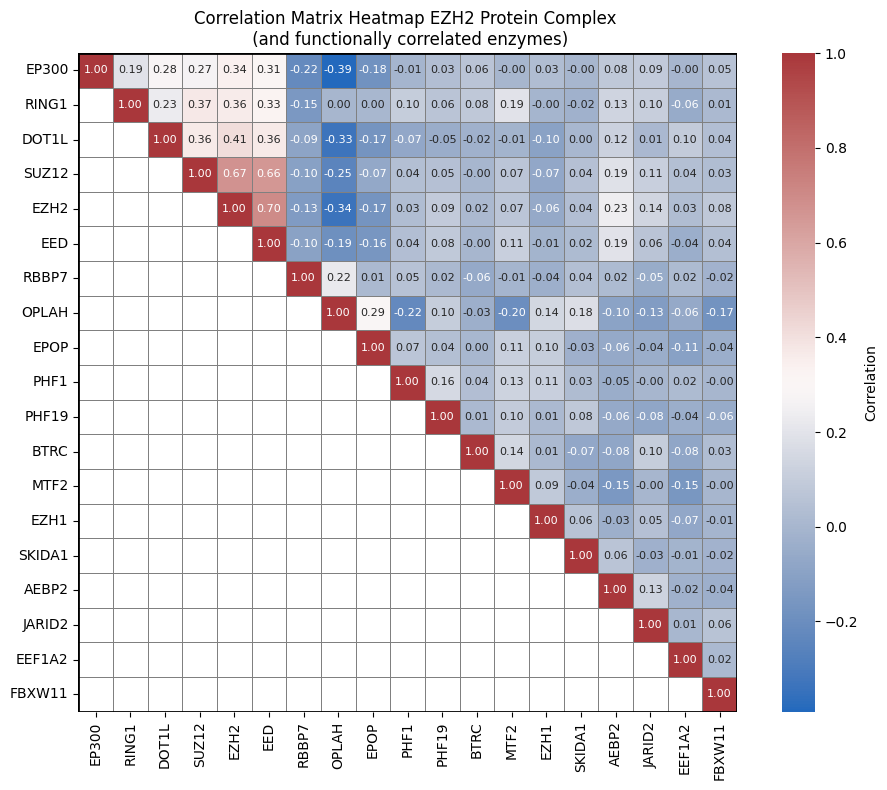

In [20]:
## Now we're plotting the genes that have been identified as high-confidence interactors of EZH2 in the set of the EZH2 dependent cells


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches
from scipy.cluster.hierarchy import linkage, leaves_list

geneset = ["EZH2", "DOT1L", "RING1", "EP300", "OPLAH"] + target_bioplex_interactors
genes_filt = [g for g in geneset if g in corr_matrix.index]
genes_filt = list(dict.fromkeys(genes_filt))

corr_matrix = depmap_data.crispr_gene_cor_matrix
corr_matrix_bioplex = corr_matrix.loc[genes_filt, genes_filt]

linkage_rows = linkage(corr_matrix_bioplex, method='average')
linkage_cols = linkage(corr_matrix_bioplex.T, method='average')

# Get the order of rows and columns from the dendrogram leaves
row_order = leaves_list(linkage_rows)
col_order = leaves_list(linkage_cols)

# Reorder the matrix
corr_clustered = corr_matrix_bioplex.iloc[row_order, :].iloc[:, col_order]


mask = np.tril(np.ones_like(corr_matrix_bioplex, dtype=bool), k=-1)  # Mask lower triangle
plt.figure(figsize=(10, 8))

ax = sns.heatmap(
    corr_clustered,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="vlag",
    square=True,
    cbar_kws={"label": "Correlation"},
    linewidths=0.5,  
    linecolor='gray',
    annot_kws={"size": 8}  
)
plt.title(f"Correlation Matrix Heatmap {target_gene} Protein Complex \n (and functionally correlated enzymes)")

# Add a rectangle frame around the heatmap
ax.add_patch(
    patches.Rectangle(
        (0, 0),  # (x, y)
        len(corr_matrix_bioplex),  # width
        len(corr_matrix_bioplex),  # height
        fill=False,
        edgecolor='black',
        linewidth=2,
        zorder=10
    )
)

plt.tight_layout()
plt.savefig("../../../../input_figures/complex.correlation.png", bbox_inches='tight')
plt.show()


We see that particular EZH2-core complex members EED and SUZ12 show a correlation. Therefore, also EED and SUZ12 should be considered as target. regarding the target mechanism validation, those two genes appear to play a rol. 

## Calculate number of dependencies with dep score of less than -0.5 for all cell lines

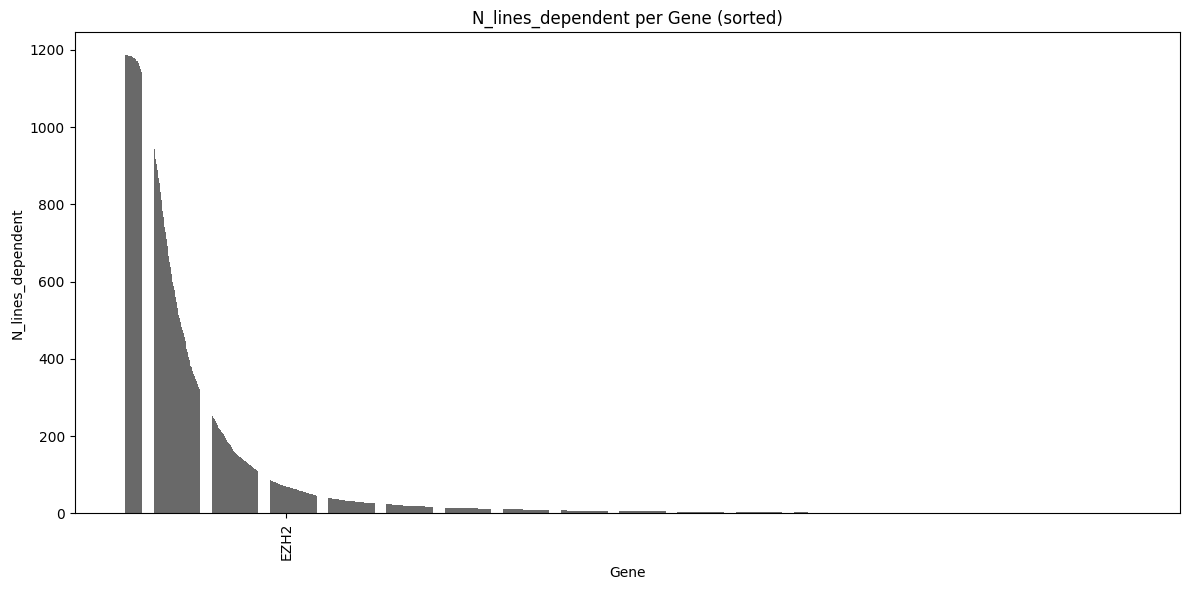

In [21]:
depmap_data = depmapData.load_data(depmap_fn)
cut_off = depmap_data.cut_off
df_crispr_dep = depmap_data.df_crispr
selected_modelIDs = depmap_data.selected_modelIDs
df_essential = depmap_data.AchillesCommonEssentialControls

df_crispr_dep.loc[selected_modelIDs, target_complex]

## Let's start by removing common essential genes from consideration
essential_genes = df_essential['gene_id']

df_binary = depmap_data.df_crispr
## Remove essential genes ##
df_binary = df_binary.drop(columns=[col for col in essential_genes if col in df_binary.columns]).copy()


df_binary = (df_binary < cut_off).astype(int).copy()
df_column_sums = df_binary.sum(axis=0)
df_column_sums = df_column_sums.sort_values(ascending=False).copy()

## add to df_merged with activity
df_column_sums = df_column_sums.to_frame(name='N_lines_dependent')

df_gene_meta = gtex_data.gene_metadata
df_gene_meta = df_gene_meta.drop('N_lines_dependent', axis=1)
df_gene_meta = df_gene_meta.join(df_column_sums, how='outer')
df_gene_meta = df_gene_meta.fillna(0)

df_gene_meta['N_lines_dependent'] = df_gene_meta['N_lines_dependent'].round().astype('Int64')

## Plot result
import matplotlib.pyplot as plt

# Filter to genes with N_lines_dependent > 0 or the target gene
mask = (df_column_sums['N_lines_dependent'] > 0) | (df_column_sums.index == target_gene)
df_filtered = df_column_sums[mask].sort_values('N_lines_dependent', ascending=False)

x = range(len(df_filtered.index))

plt.figure(figsize=(12, 6))

# Plot all bars in dark grey, no border
plt.bar(
    x,
    df_filtered['N_lines_dependent'],
    color='dimgray',
    edgecolor='none'
)

# Highlight the target gene in red if present
if target_gene in df_filtered.index:
    target_idx = list(df_filtered.index).index(target_gene)
    plt.bar(
        target_idx,
        df_filtered.loc[target_gene, 'N_lines_dependent'],
        color='red',
        edgecolor='none',
        width = 1
    )

# Remove all x-ticks and labels
plt.xticks([], [])

# Add only the target_gene label at the correct position
if target_gene in df_filtered.index:
    plt.xticks([target_idx], [target_gene], rotation=90)

plt.ylabel('N_lines_dependent')
plt.xlabel('Gene')
plt.title('N_lines_dependent per Gene (sorted)')
plt.tight_layout()
plt.show()

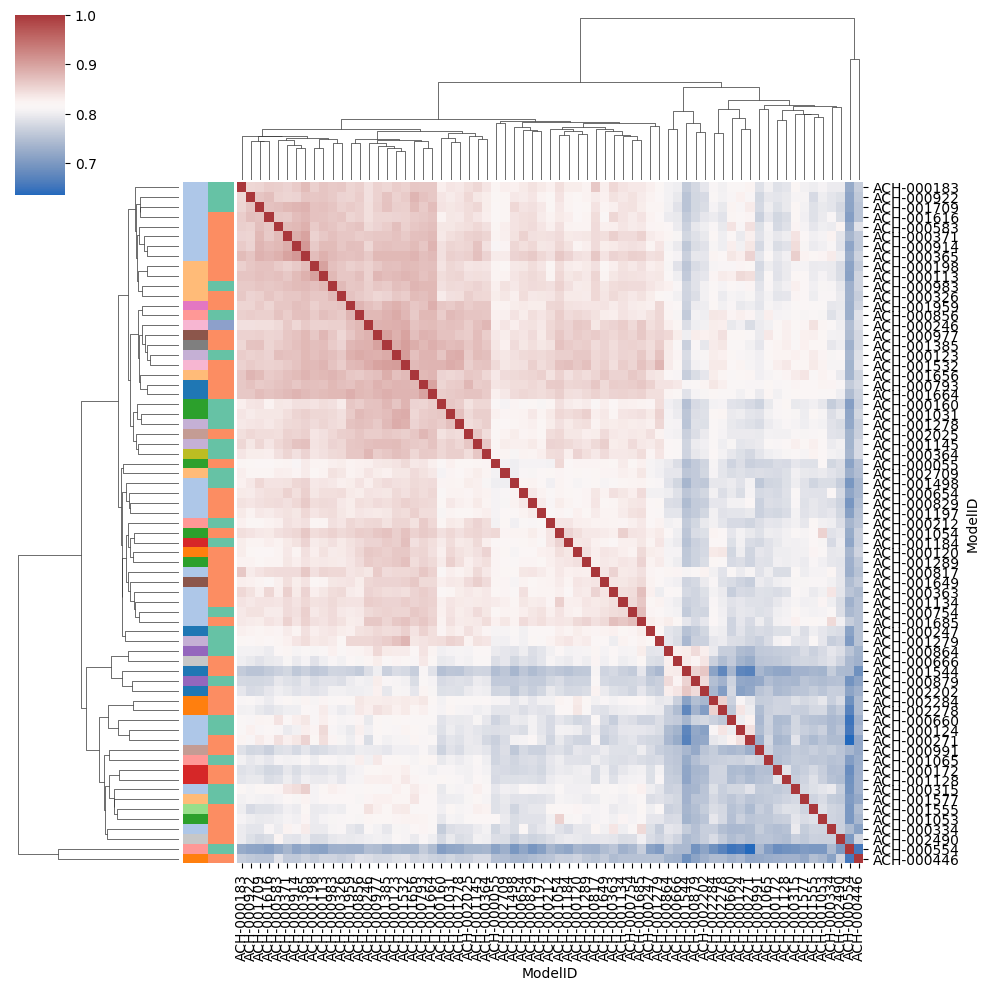

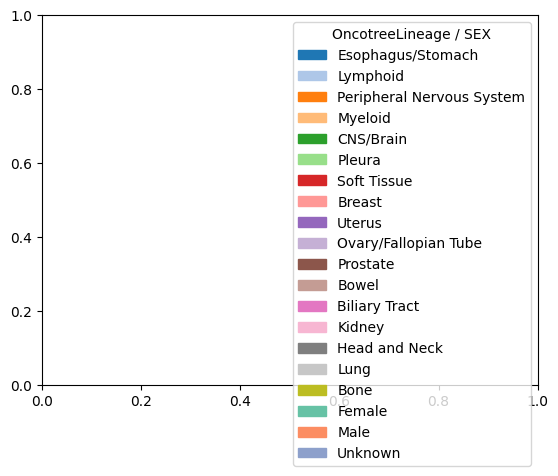

In [22]:
## Correlation between selected models
df_subset = depmap_data.df_crispr
selected_modelIDs = depmap_data.selected_modelIDs
df_subset = df_subset.loc[selected_modelIDs].copy()
df_meta_dep = depmap_data.df_target_score

model_corr_matrix = df_subset.T.corr(method='pearson')
depmap_data.model_corr_matrix = model_corr_matrix
depmap_data.save_data(depmap_fn)

## Subset to selected models
df_sel_model_cor = model_corr_matrix.loc[selected_modelIDs, selected_modelIDs]

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assume df_sel_model_cor is your correlation matrix (square, with modelIDs as index/columns)
# and df_meta_dep is your metadata DataFrame with OncotreeLineage as a column and modelID as index

# Existing lineage color mapping
lineages = df_meta_dep.loc[df_sel_model_cor.index, 'OncotreeLineage']
unique_lineages = lineages.unique()
palette = sns.color_palette("tab20", n_colors=len(unique_lineages))
lineage_color_dict = dict(zip(unique_lineages, palette))
row_colors_lineage = lineages.map(lineage_color_dict)

# New Sex color mapping
sexes = df_meta_dep.loc[df_sel_model_cor.index, 'Sex']
unique_sexes = sexes.unique()
sex_palette = sns.color_palette("Set2", n_colors=len(unique_sexes))
sex_color_dict = dict(zip(unique_sexes, sex_palette))
row_colors_sex = sexes.map(sex_color_dict)

# Combine both color bars
row_colors = [row_colors_lineage, row_colors_sex]

# Plot heatmap with two color bars
sns.clustermap(
    df_sel_model_cor,
    row_colors=row_colors,
    cmap='vlag',
    figsize=(10, 10),
    xticklabels=True,
    yticklabels=True
)

plt.savefig("../../../../input_figures/target.gene.model.correlation.png", bbox_inches='tight')
plt.show()

# Add legends for both color bars
import matplotlib.patches as mpatches
handles_lineage = [mpatches.Patch(color=color, label=label) for label, color in lineage_color_dict.items()]
handles_sex = [mpatches.Patch(color=color, label=label) for label, color in sex_color_dict.items()]
plt.legend(handles=handles_lineage + handles_sex, title='OncotreeLineage / SEX', bbox_to_anchor=(1, 1))
plt.show()


## Expression vs. Dependency score 

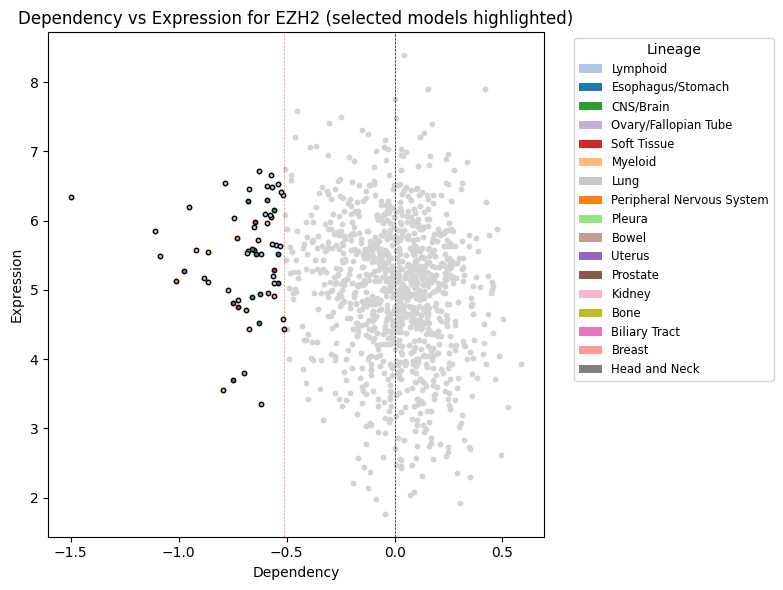

In [126]:
df_expr = depmap_data.df_tpm[[target_gene]]
df_dep = depmap_data.df_crispr[[target_gene]]
df_meta = depmap_data.df_target_score
selected_modelIDs = depmap_data.selected_modelIDs

# Prepare meta data subset first
df_meta_sel = df_meta.loc[selected_modelIDs, ['OncotreeLineage']].copy()

# Prepare expression and dependency DataFrames
df_expr = depmap_data.df_tpm[[target_gene]].rename(columns={target_gene: f"{target_gene}_expr"})
df_dep = depmap_data.df_crispr[[target_gene]].rename(columns={target_gene: f"{target_gene}_dep"})

# Merge expression and dependency on index (inner join keeps only common ModelIDs)
df_shortlist = df_expr.merge(df_dep, left_index=True, right_index=True)

# Merge with meta data (inner join keeps only ModelIDs present in all)
df_shortlist = df_shortlist.merge(df_meta_sel, left_index=True, right_index=True, how='left')

# Now df_shortlist has columns: [f"{target_gene}_expr", f"{target_gene}_dep", "OncotreeLineage"]

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

is_selected = df_shortlist.index.isin(selected_modelIDs)

plt.figure(figsize=(8, 6))

# Plot all points in grey, smaller dots (y vs x)
plt.axvline(0, color='black', linewidth=0.5, linestyle='--')
plt.axvline(cut_off, color='red', linewidth=0.5, linestyle='--', alpha=0.5)
plt.ylabel('Expression')
plt.xlabel('Dependency')
plt.title(f'Dependency vs Expression for {target_gene} (selected models highlighted)')

plt.scatter(
    df_shortlist[f"{target_gene}_dep"],
    df_shortlist[f"{target_gene}_expr"],
    color='lightgray',
    s=10,
    label='Other models'
)

# Plot selected points in color, slightly larger (y vs x)
for modelID in df_shortlist.index[is_selected]:
    row = df_shortlist.loc[modelID]
    lineage = row['OncotreeLineage']
    color = lineage_color_dict.get(lineage, 'red')
    plt.scatter(
        row[f"{target_gene}_dep"],
        row[f"{target_gene}_expr"],
        color=color,
        edgecolor='black',
        s=10,
        label=lineage
    )



unique_lineages = list({df_shortlist.loc[modelID, 'OncotreeLineage'] for modelID in df_shortlist.index[is_selected]})
lineage_handles = [Patch(facecolor=lineage_color_dict[lin], label=lin) for lin in unique_lineages if lin in lineage_color_dict]
if lineage_handles:
    plt.legend(handles=lineage_handles, title='Lineage', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', frameon=True)

plt.tight_layout()
plt.show()

# Find repurposing drug candidates

In [132]:
# Strategy: 
# Investigate the cell lines with target gene dependencies. 
# Find the drug dependencies in those cell lines
# Rank the drugs by number of co-sensitivity
depmap_data = depmapData.load_data(depmap_fn)
selected_modelIDs = depmap_data.selected_modelIDs
df_drugs = depmap_data.df_drugs

## Subset 
selected_modelIDs_in_drugs = [mid for mid in selected_modelIDs if mid in df_drugs.index]
df_drugs = df_drugs.loc[selected_modelIDs_in_drugs]
df_drugs = df_drugs.fillna(0)

## We'll calculate a cut-off for each row each row (cell line) as two standard deviations ##
row_mean = df_drugs.mean(axis=1)
row_std = df_drugs.std(axis=1)
row_cut_off = row_mean - 2 * row_std

df_drug_binary = (df_drugs.lt(row_cut_off, axis=0)).astype(int)

df_colsums = df_drug_binary.sum(axis=0).reset_index()
df_colsums = df_colsums.rename(columns={'SampleIDs': 'Drug_ID', 0: f'N_lines_with_{target_gene}_sensitivity'})
df_colsums = df_colsums.sort_values(f'N_lines_with_{target_gene}_sensitivity', ascending=False)
df_colsums = df_colsums.reset_index(drop=True)

df_colsums.head(30)


,Drug_ID,N_lines_with_EZH2_sensitivity
0,BRD:BRD-K00003207-001-01-9,34
1,BRD:BRD-K00003404-001-01-9,34
2,BRD:BRD-K38018935-001-01-1,34
3,BRD:BRD-K00003376-001-01-9,34
4,BRD:BRD-A45499626-001-04-9,34
5,BRD:BRD-K00003203-001-01-9,34
6,BRD:BRD-K00003533-001-01-9,34
7,BRD:BRD-K00003144-001-01-9,34
8,BRD:BRD-K00003354-001-01-9,34
9,BRD:BRD-K00003343-001-01-9,34


In [ ]:
# Summary

Selection: 
    - Lymphoid tissue
    - Male and Female (e.g. 3 + +
    - Pick of cell line system suiting experimental requirements, e.g. technical requirements for assyast)
    - See rankes short list below

## Ranked shortlist creation ##
